# Thành viên nhóm 10:
## Nguyễn Hùng Anh 21064051
## Trương Hải Anh Thắng 21062461

### Tiền xử lý dữ liệu

In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
def extract_hog_features(image_path, visualize=True):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh xám
    image = cv2.resize(image, (128, 128))  # Resize ảnh về 128x128

    # Trích xuất đặc trưng HOG
    features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                              orientations=9, block_norm='L2-Hys', visualize=visualize)

    return features, hog_image, image

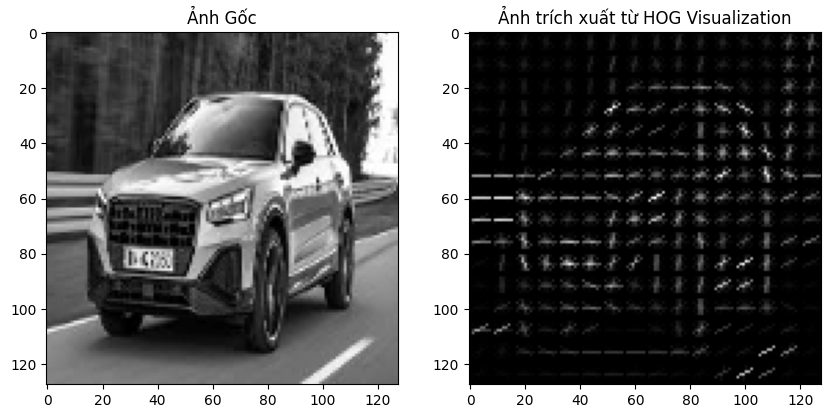

In [3]:
# Thử nghiệm với một ảnh trong thư mục train
image_path = "../project1/train/Audi/1.jpg"
# Thử nghiệm trích xuất HOG
features, hog_image, original_image = extract_hog_features(image_path)

# Hiển thị ảnh gốc và ảnh HOG visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Ảnh Gốc")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap="gray")
plt.title("Ảnh trích xuất từ HOG Visualization")

plt.show()

In [4]:
def load_data(directory):
    X = []  # Danh sách chứa đặc trưng của ảnh
    y = []  # Danh sách chứa nhãn (tên thư mục)
    
    for label in os.listdir(directory):  
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            for file in os.listdir(label_path): 
                file_path = os.path.join(label_path, file)
                features, _, _ = extract_hog_features(file_path)  # Trích xuất HOG
                X.append(features)
                y.append(label)
    
    return np.array(X), np.array(y)



In [5]:
# Đọc dữ liệu từ thư mục train
train_dir = "../project1/train"
test_dir = "../project1/test"

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

# Chuyển đổi nhãn thành số
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

print(f"Số lượng ảnh trong tập huấn luyện: {len(X_train)}")
print(f"Số lượng ảnh trong tập kiểm tra: {len(X_test)}")


Số lượng ảnh trong tập huấn luyện: 3352
Số lượng ảnh trong tập kiểm tra: 813


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Huấn luyện mô hình KNN với K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred = knn.predict(X_test_scaled)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác: {accuracy * 100:.2f}%")

Độ chính xác: 56.33%


Nhận xét về độ chính xác:
- Độ chính xác 56.33% cho mô hình KNN chưa thực sự cao

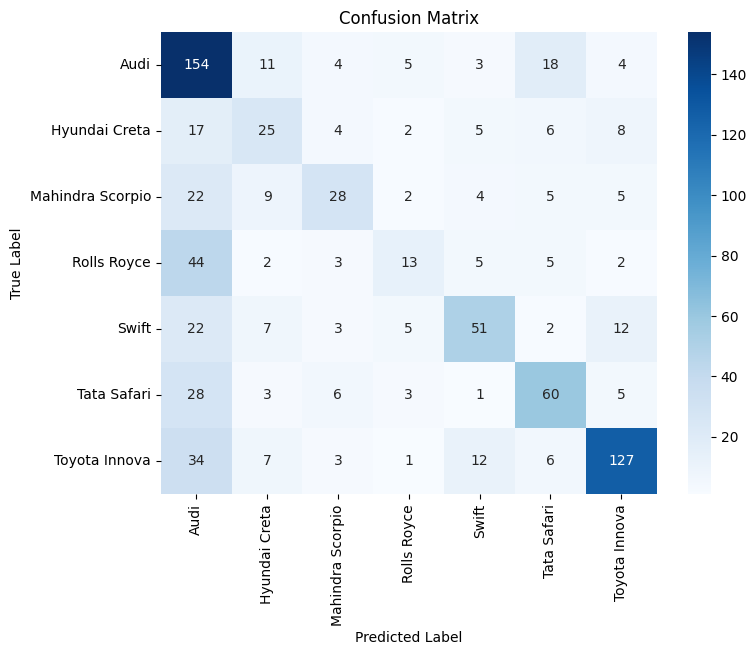

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Nhận xét về ma trận nhầm lẫn: 
1. Các lớp có dự đoán tốt:
- Audi (154 đúng) và Toyota Innova (127 đúng): Hai lớp này có số lượng dự đoán đúng cao nhất.
- Tata Safari (60 đúng) và Swift (51 đúng): Cũng có độ chính xác tương đối tốt.

2. Các lớp có dự đoán kém:
- Rolls Royce: Chỉ có 13 ảnh được dự đoán đúng, trong khi có nhiều nhầm lẫn với Audi (44 ảnh bị nhầm).
- Hyundai Creta (25 đúng) và Mahindra Scorpio (28 đúng): Có tỷ lệ nhầm lẫn khá cao với các lớp khác.

In [9]:
# Báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Báo cáo phân loại:
                  precision    recall  f1-score   support

            Audi       0.48      0.77      0.59       199
   Hyundai Creta       0.39      0.37      0.38        67
Mahindra Scorpio       0.55      0.37      0.44        75
     Rolls Royce       0.42      0.18      0.25        74
           Swift       0.63      0.50      0.56       102
     Tata Safari       0.59      0.57      0.58       106
   Toyota Innova       0.78      0.67      0.72       190

        accuracy                           0.56       813
       macro avg       0.55      0.49      0.50       813
    weighted avg       0.58      0.56      0.55       813



Nhận xét về báo cáo phân loại:
1. Các lớp có hiệu suất tốt: 
- Toyota Innova có hiệu suất cao nhất với F1-score là 0.72. Precision (0.78) cao hơn recall (0.67), nghĩa là mô hình có xu hướng ít mắc lỗi nhận diện nhầm.
- Audi có recall cao (0.77) nhưng precision thấp (0.48), có nghĩa là mô hình nhận diện đúng nhiều mẫu Audi nhưng cũng dễ nhầm lẫn Audi với các loại xe khác.
2. Các lớp có hiệu suất kém
- Rolls Royce có F1-score thấp nhất (0.25) do recall rất thấp (0.18), nghĩa là nhiều mẫu Rolls Royce bị phân loại sai.
- Hyundai Creta & Mahindra Scorpio cũng có F1-score khá thấp (0.38 & 0.44), cho thấy mô hình chưa phân biệt rõ hai loại xe này.


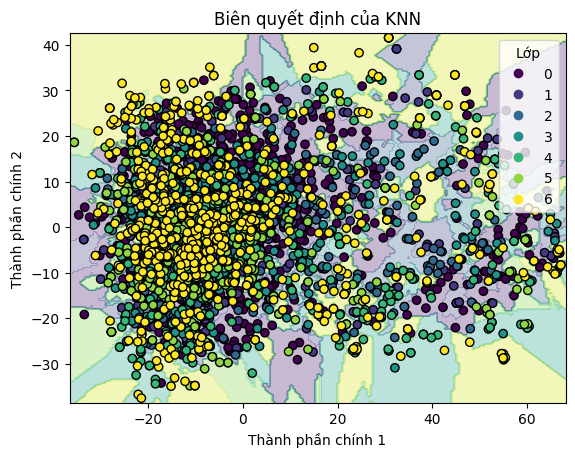

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Giảm dữ liệu xuống 2D bằng PCA để vẽ
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Huấn luyện KNN trên dữ liệu đã giảm chiều
knn_2d = KNeighborsClassifier(n_neighbors=5)
knn_2d.fit(X_train_pca, y_train)

# Tạo lưới điểm để vẽ biên quyết định
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Dự đoán trên lưới điểm
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Vẽ biểu đồ
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Lớp")
plt.title("Biên quyết định của KNN")
plt.xlabel("Thành phần chính 1")
plt.ylabel("Thành phần chính 2")
plt.show()


Nhận xét: 
- Dữ liệu bị chồng chéo! Vì các lớp xen kẽ khá nhiều, cho thấy KNN có thể không phân loại tốt với dữ liệu này.
- Khó phân biệt màu sắc! 

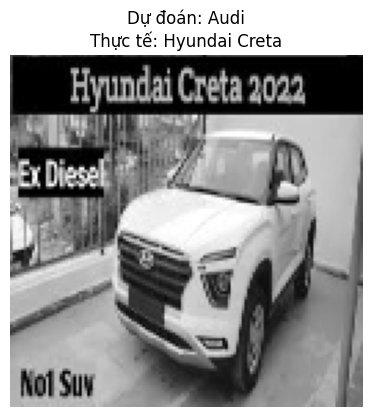

In [27]:
import random

def get_random_image(directory):
    car_brands = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
    random_brand = random.choice(car_brands)  # Chọn một thương hiệu ngẫu nhiên
    brand_path = os.path.join(directory, random_brand)

    image_files = [file for file in os.listdir(brand_path) if file.endswith(('.jpg', '.png', '.jpeg'))]
    random_image = random.choice(image_files)  # Chọn một ảnh ngẫu nhiên
    return os.path.join(brand_path, random_image), random_brand

def predict_random_image(directory):
    """ Chọn một ảnh ngẫu nhiên từ thư mục và dự đoán """
    image_path, actual_label = get_random_image(directory)
    if image_path is None:
        print("Không tìm thấy ảnh hợp lệ!")
        return

    features, hog_image, image = extract_hog_features(image_path)
    features = scaler.transform([features])  # Chuẩn hóa đặc trưng
    prediction = knn.predict(features)
    predicted_label = encoder.inverse_transform(prediction)[0]  # Lấy tên dự đoán

    # Hiển thị ảnh và kết quả dự đoán
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Dự đoán: {predicted_label}\nThực tế: {actual_label}", fontsize=12)
    plt.axis("off")
    
    plt.show()

# Gọi hàm để dự đoán ảnh ngẫu nhiên
predict_random_image(test_dir)
